<a href="https://colab.research.google.com/github/SalarShafiee/Image-classification/blob/main/ViT_implementation_with%20STNF%20modification%2026%2C09%2C2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/medical-image-dataset-brain-tumor-detection")

print("Path to dataset files:", path)

100%|██████████| 297M/297M [00:07<00:00, 40.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

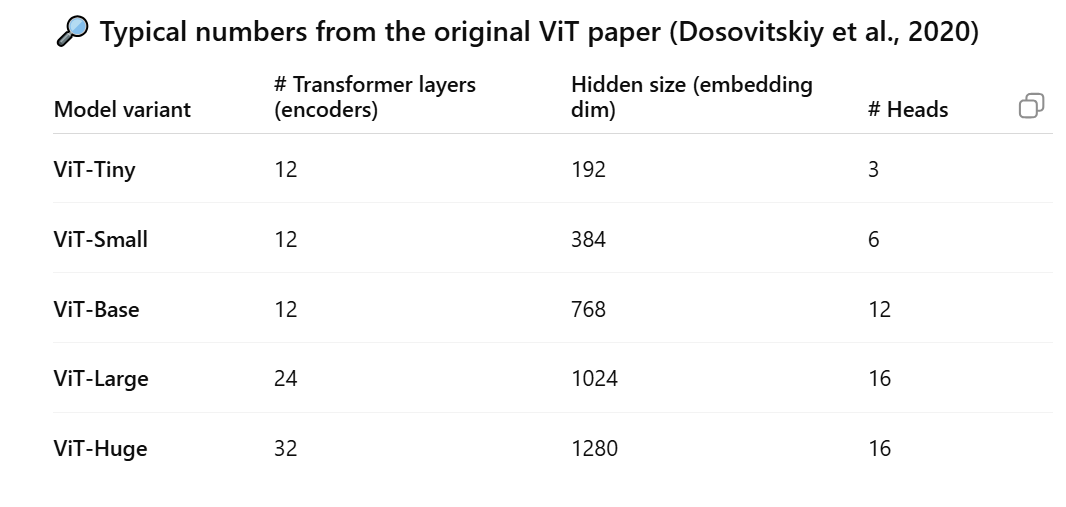

In [ ]:
import os

yolov11_path = '/root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11'

print(f"Contents of {yolov11_path}:")
print(os.listdir(yolov11_path))

# Let's explore the 'valid' directory as it was mentioned in data.yaml and the previous output
valid_dir = os.path.join(yolov11_path, 'valid')
if os.path.isdir(valid_dir):
    print(f"\nContents of {valid_dir}:")
    print(os.listdir(valid_dir))

    # Look inside 'images' and 'labels' if they exist within 'valid'
    valid_images_dir = os.path.join(valid_dir, 'images')
    if os.path.isdir(valid_images_dir):
        print(f"\nContents of {valid_images_dir} (first 10 items):")
        print(os.listdir(valid_images_dir)[:10]) # Print only first 10 items to keep output clean

    valid_labels_dir = os.path.join(valid_dir, 'labels')
    if os.path.isdir(valid_labels_dir):
        print(f"\nContents of {valid_labels_dir} (first 10 items):")
        print(os.listdir(valid_labels_dir)[:10]) # Print only first 10 items

Contents of /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11:
['test', 'data.yaml', 'train', 'valid']

Contents of /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11/valid:
['images', 'labels']

Contents of /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11/valid/images (first 10 items):
['617_jpg.rf.e5cde736ae8b0c76a2009cf4b7de32d8.jpg', '530_jpg.rf.48b74a5402e8b134229b863545a96a4a.jpg', '1908_jpg.rf.de89021910809fe1ff95e360442bb494.jpg', '1093_jpg.rf.2b04cd4ee5e1c616361562f558af8032.jpg', '810_jpg.rf.8b0252bbe0bb68dae0ce2e68111c62c7.jpg', '1923_jpg.rf.f882c9aa35eb1c893fbe9306ca3e0bae.jpg', '1952_jpg.rf.96ec0bb0761e8e266a37a858634a7a72.jpg', '1409_jpg.rf.320b6c564d7381b2054b347a3b36d5d9.jpg', '1442_jpg.rf.8484efb3dc752acae3d58fa795bd51b7.jpg', '325_jpg.rf.59321ad31

In [ ]:
import os
import cv2
import numpy as np
import yaml

def load_images_and_labels_from_dirs(image_dir, label_dir, target_size=(32, 32)):
    """
    Loads images and labels from specified directories following a YOLO-like structure.

    Args:
        image_dir (str): Path to the directory containing image files.
        label_dir (str): Path to the directory containing label files (YOLO format).
        target_size (tuple): The target size to resize images to (width, height).

    Returns:
        tuple: A tuple containing two numpy arrays:
               - images: Array of loaded and resized images.
               - labels: Array of corresponding class labels.
    """
    images = []
    labels = []

    if not os.path.isdir(image_dir):
        print(f"Error: Image directory not found at {image_dir}")
        return np.array(images), np.array(labels)

    if not os.path.isdir(label_dir):
        print(f"Error: Label directory not found at {label_dir}")
        # Decide how to handle missing label directory - here we return empty arrays
        return np.array(images), np.array(labels)


    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(image_files)} image files in {image_dir}")

    for filename in image_files:
        image_path = os.path.join(image_dir, filename)
        # Assuming label file has the same base name but with .txt extension
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(label_dir, label_filename)

        try:
            # Read the image
            img = cv2.imread(image_path)
            if img is not None:
                # Convert to RGB (OpenCV reads as BGR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Resize image to a consistent size
                img_resized = cv2.resize(img, target_size)
                images.append(img_resized)

                # Read the label file
                if os.path.isfile(label_path):
                    with open(label_path, 'r') as lbl_f:
                        # Assuming one object per image for simplicity and classification task
                        # The first number in the YOLO label file is the class index
                        first_line = lbl_f.readline().strip()
                        if first_line:
                            try:
                                class_index = int(first_line.split()[0])
                                labels.append(class_index)
                            except ValueError:
                                print(f"Warning: Invalid class index in label file {label_path}. Skipping image.")
                                images.pop() # Remove the image added earlier
                        else:
                             # Handle images with no objects if necessary, here we skip them
                             print(f"Warning: Label file empty or invalid for {image_path}. Skipping image.")
                             images.pop() # Remove the image added earlier if no valid label found
                else:
                     print(f"Warning: Label file not found for {image_path}. Skipping image.")
                     images.pop() # Remove the image added earlier if no label found


            else:
                print(f"Warning: Could not read image file: {image_path}")
        except Exception as e:
            print(f"Error loading image or label {image_path}: {e}")

    print(f"Successfully loaded {len(images)} images and {len(labels)} labels from {image_dir}")

    return np.array(images), np.array(labels)

# Define the base directory for the YOLOv11 dataset
dataset_yolov11_path =  "/root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11"

# Define paths to image and label directories for each split
train_images_dir = os.path.join(dataset_yolov11_path, 'train', 'images')
train_labels_dir = os.path.join(dataset_yolov11_path, 'train', 'labels')

valid_images_dir = os.path.join(dataset_yolov11_path, 'valid', 'images')
valid_labels_dir = os.path.join(dataset_yolov11_path, 'valid', 'labels')

test_images_dir = os.path.join(dataset_yolov11_path, 'test', 'images')
test_labels_dir = os.path.join(dataset_yolov11_path, 'test', 'labels')

# Load data for each split using the function
x_train, y_train = load_images_and_labels_from_dirs(train_images_dir, train_labels_dir)
x_val, y_val = load_images_and_labels_from_dirs(valid_images_dir, valid_labels_dir)
x_test, y_test = load_images_and_labels_from_dirs(test_images_dir, test_labels_dir)

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("\n--- Dataset Summary ---")
print("Train shapes:", x_train.shape, y_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape)
print("Test shapes:", x_test.shape, y_test.shape)
print(f"Loaded {len(x_train)} training images, {len(x_val)} validation images, and {len(x_test)} test images.")

# Optional: Load class names from data.yaml if needed for display or further processing
data_yaml_path = os.path.join(dataset_yolov11_path, 'data.yaml')
class_names = []
if os.path.isfile(data_yaml_path):
    try:
        with open(data_yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
            if 'names' in data_yaml:
                class_names = data_yaml['names']
                print("\nClasses and their numerical labels:")
                for i, class_name in enumerate(class_names):
                    print(f"  {class_name}: {i}")
    except Exception as e:
        print(f"Error loading class names from data.yaml: {e}")

Found 2144 image files in /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11/train/images
Successfully loaded 2144 images and 2144 labels from /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11/train/images
Found 612 image files in /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11/valid/images
Successfully loaded 612 images and 612 labels from /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11/valid/images
Found 308 image files in /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/versions/5/BrainTumor/BrainTumorYolov11/test/images
Successfully loaded 308 images and 308 labels from /root/.cache/kagglehub/datasets/pkdarabi/medical-image-dataset-brain-tumor-detec

In [ ]:
if __name__=='__main__':
    config={}
    config['num_heads']=12
    config['num_layers']=12
    config['hidden_dim']=768
    config['mlp_dim']=3072
    config['dropout_rate']=0.3
    config['num_patches']=64
    config['patch_size']=4
    config['num_channels']=3


In [ ]:
# -------------------------------------------------------------------
# RMSNorm layer
class RMSNorm(Layer):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        # Calculate RMS
        rms = tf.sqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + self.epsilon)
        # Apply RMSNorm
        return x * self.scale / rms

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Embedding, Concatenate, Input
from tensorflow.keras.models import Model

# -------------------------------------------------------------------
# Class token
class Classtoken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.keras.initializers.RandomNormal()
        self.w = self.add_weight(
            shape=(1, 1, input_shape[-1]),
            initializer=w_init,
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim]) #(None,1,48)
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

# -------------------------------------------------------------------
# MLP block (instead of creating Dense+Dropout each call)
class MLPBlock(Layer):
    def __init__(self, cf):
        super().__init__()
        # Implement SwiGLU activation
        self.fc1 = Dense(cf['mlp_dim']) # Output dimension mlp_dim
        self.fc2 = Dense(cf['mlp_dim']) # Output dimension mlp_dim for element-wise multiplication
        self.fc3 = Dense(cf['hidden_dim']) # Project back to hidden_dim
        self.drop1 = Dropout(cf['dropout_rate'])
        self.drop2 = Dropout(0.2)

    def call(self, x):
        # SwiGLU activation
        x_gelu = tf.nn.gelu(self.fc1(x))
        x = x_gelu * self.fc2(x) # Element-wise multiplication
        x = self.drop1(x)
        x = self.fc3(x) # Project back to hidden_dim
        x = self.drop2(x)
        return x

# -------------------------------------------------------------------
# Transformer encoder block
class TransformerEncoder(Layer):
    def __init__(self, cf):
        super().__init__()
        # Using RMSNorm as implemented in a separate cell
        self.norm1 = RMSNorm()
        self.attn = MultiHeadAttention(num_heads=cf['num_heads'], key_dim=cf['hidden_dim'])
        self.add1 = Add()

        # Using RMSNorm as implemented in a separate cell
        self.norm2 = RMSNorm()
        self.mlp = MLPBlock(cf)
        self.add2 = Add()

    def call(self, x):
        # Pre-Norm for Attention
        skip = x
        x = self.norm1(x) # Apply normalization before attention
        x = self.attn(x, x)
        x = self.add1([skip, x])

        # Pre-Norm for MLP
        skip = x
        x = self.norm2(x) # Apply normalization before MLP
        x = self.mlp(x)
        x = self.add2([skip, x])
        return x

# -------------------------------------------------------------------
# Vision Transformer
def ViT(cf):
    # Input
    Input_shape = (cf['num_patches'], cf['patch_size']*cf['patch_size']*cf['num_channels'])
    inputs = Input(Input_shape)  #  (None, 64, 48) for CIFAR

    # Patch embedding
    patch_embed = Dense(cf['hidden_dim'])(inputs) # (None, 64,48 )
    positions = tf.range(start=0, limit=cf['num_patches'], delta=1)
    pos_embed = Embedding(input_dim=cf['num_patches'], output_dim=cf['hidden_dim'])(positions) #(64,48)
    x = patch_embed + pos_embed
    print(patch_embed.shape, pos_embed.shape )

    # Class token
    cls_token = Classtoken()(x)
    x = Concatenate(axis=1)([cls_token, x])

    # Transformer encoders
    for _ in range(cf['num_layers']):
        x = TransformerEncoder(cf)(x)

    # Head
    # Apply normalization before the head as in Pre-Norm
    x = RMSNorm()(x) # Using RMSNorm as implemented in a separate cell
    x = x[:, 0, :]  # CLS token
    x = Dropout(0.1)(x)
    outputs = Dense(3, activation="softmax")(x)

    return Model(inputs, outputs)

In [ ]:
model=ViT(config)

(None, 64, 768) (64, 768)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 48)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 768)   │     37,632 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 768)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classtoken          │ (None, 1, 768)    │        768 │ add[0][0]         │
│ (Classtoken)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65, 768)   │          0 │ classtoken[0][0], │
│ (Concatenate)       │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, 65, 768)   │ 35,426,304 │ concatenate[0][0] │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 65, 768)   │ 35,426,304 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 425,157,123 (1.58 GB)

 Trainable params: 425,157,123 (1.58 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
import tensorflow as tf

# take  images (batch, 32, 32, 3) and convert to patches
def preprocess_for_vit(images, patch_size=config['patch_size']):
    # extract non-overlapping patches of size 4x4
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )  # (batch, 8, 8, patch_size*patch_size*3)

    # flatten grid of patches → sequence
    patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_size*patch_size*3])
    return patches

In [ ]:
x_train_patches = preprocess_for_vit(x_train)
x_val_patches   = preprocess_for_vit(x_val)
x_test_patches  = preprocess_for_vit(x_test)

print(x_train_patches.shape)  # (2144, 1024, 48)
print(x_val_patches.shape)    # (612, 1024, 48)
print(x_test_patches.shape)   # (308, 1024, 48)


(2144, 64, 48)
(612, 64, 48)
(308, 64, 48)


In [ ]:

from tensorflow.keras.optimizers import Adam


model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 2. Instantiate EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 3. Instantiate ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7
)

# 4. Instantiate ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

# 5. Create a list of callbacks
callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

# 6. Modify the model.fit call to include the callbacks
model.fit(
    x=x_train_patches,
    y=y_train,
    batch_size=32,
    epochs=50, # Set epochs higher to allow callbacks to trigger
    verbose="auto",
    callbacks=callbacks_list,
    validation_data=(x_val_patches, y_val),
)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 970s 14s/step - accuracy: 0.3862 - loss: 3.6954 - val_accuracy: 0.4657 - val_loss: 1.1052 - learning_rate: 3.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1061s 15s/step - accuracy: 0.4179 - loss: 1.1335 - val_accuracy: 0.4657 - val_loss: 0.9965 - learning_rate: 3.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1114s 17s/step - accuracy: 0.4844 - loss: 1.0288 - val_accuracy: 0.6634 - val_loss: 0.7344 - learning_rate: 3.0000e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.5865 - loss: 0.8628 - val_accuracy: 0.6536 - val_loss: 0.9101 - learning_rate: 3.0000e-04
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6047 - loss: 0.8667